In [8]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt

import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
from SplineEncodingModel.LinearRegressionSpline import EncodingModel, NBDecodingModel
from SplineEncodingModel import PopDecodingCV as pdcv
import matplotlib.gridspec as gridspec
import pickle

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [48]:
# find all DG data
df = pp.load_session_db()
df = df[df['RewardCount']>20]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df.ImagingRegion=='DG']

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [50]:
df

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
900,4139219.2,25_10_2018,2,TwoTower_Timeout,49,1,DG,2018-10-25,G:\My Drive\VR_Data\TwoTower\4139219.2\25_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.2\25_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.2\25_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.2\25_10_2...
924,4139219.2,26_10_2018,6,TwoTower_Timeout,50,1,DG,2018-10-26,G:\My Drive\VR_Data\TwoTower\4139219.2\26_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.2\26_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.2\26_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.2\26_10_2...
903,4139219.3,25_10_2018,2,TwoTower_Timeout,32,1,DG,2018-10-25,G:\My Drive\VR_Data\TwoTower\4139219.3\25_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\25_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\25_10_2...,G:\My Drive\2P_Data\TwoTower\4139219.3\25_10_2...
1275,4139251.1,02_02_2019,4,Reversal,51,1,DG,2019-02-02,G:\My Drive\VR_Data\TwoTower\4139251.1\02_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139251.1\02_02_2...,G:\My Drive\2P_Data\TwoTower\4139251.1\02_02_2...
1296,4139251.1,04_02_2019,4,Reversal,52,1,DG,2019-02-04,G:\My Drive\VR_Data\TwoTower\4139251.1\04_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139251.1\04_02_2...,G:\My Drive\2P_Data\TwoTower\4139251.1\04_02_2...
1332,4139251.1,05_02_2019,7,Reversal,44,1,DG,2019-02-05,G:\My Drive\VR_Data\TwoTower\4139251.1\05_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139251.1\05_02_2...,G:\My Drive\2P_Data\TwoTower\4139251.1\05_02_2...
1263,4139260.1,01_02_2019,4,Reversal,52,1,DG,2019-02-01,G:\My Drive\VR_Data\TwoTower\4139260.1\01_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139260.1\01_02_2...,G:\My Drive\2P_Data\TwoTower\4139260.1\01_02_2...
1336,4139260.1,05_02_2019,3,Reversal,38,1,DG,2019-02-05,G:\My Drive\VR_Data\TwoTower\4139260.1\05_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139260.1\05_02_2...,G:\My Drive\2P_Data\TwoTower\4139260.1\05_02_2...
1393,4139260.1,08_02_2019,4,Reversal,74,1,DG,2019-02-08,G:\My Drive\VR_Data\TwoTower\4139260.1\08_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139260.1\08_02_2...,G:\My Drive\2P_Data\TwoTower\4139260.1\08_02_2...
1314,4139260.2,04_02_2019,8,TwoTower_foraging,60,1,DG,2019-02-04,G:\My Drive\VR_Data\TwoTower\4139260.2\04_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139260.2\04_02_2...,G:\My Drive\2P_Data\TwoTower\4139260.2\04_02_2...


In [54]:
# load one session and plot transients, plot it next to CA1 data from same animal
sess = df.iloc[-2]

VRDat,C, S, A = pp.load_scan_sess(sess)
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)


num aberrant ttls 0.0
20323 (20323,) (20323, 21) 69551
(69551,) (69551, 21)
frame diff 0


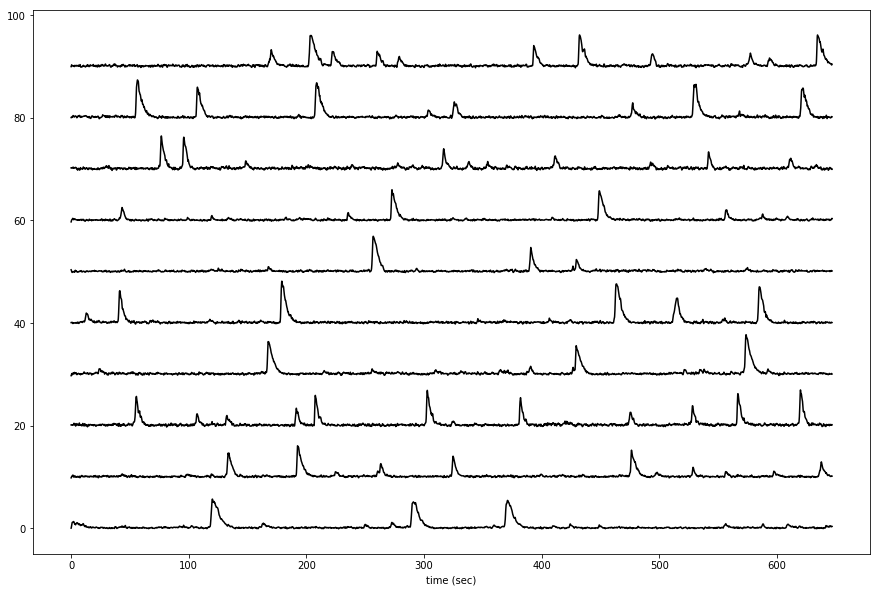

In [60]:
f,ax = plt.subplots(figsize=[15,10])
for i in range(10):
    ax.plot(np.arange(0,10000/15.46,1/15.46),C[:10000,i]+i*10,color='black')
    
ax.set_xlabel('time (sec)')
f.savefig("G:\\My Drive\\manuscripts\\DG_R01Data\\example_dff.pdf",format='pdf')
# ax.set_ylim([0,12])


In [53]:
print(sess)

MouseName                                                4139261.2
DateFolder                                              07_02_2019
SessionNumber                                                    3
Track                                                     Reversal
RewardCount                                                     69
Imaging                                                          1
ImagingRegion                                                   DG
DateTime                                       2019-02-07 00:00:00
data file        G:\My Drive\VR_Data\TwoTower\4139261.2\07_02_2...
scanfile                                                      None
scanmat          G:\My Drive\2P_Data\TwoTower\4139261.2\07_02_2...
s2pfolder        G:\My Drive\2P_Data\TwoTower\4139261.2\07_02_2...
Name: 1381, dtype: object


In [62]:
# similarity matrix

print(S_trial_mat.shape)

# place cells

(90, 45, 333)


In [66]:
def pretty_plot(sess,cells):
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)

    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,
                                                                              bin_size=10,speed=VRDat['speed']._values)
    S_trial_mat[np.isnan(S_trial_mat)]=1E-10
    effMorph = trial_info['morphs']+trial_info['bckgndJitter']+trial_info['wallJitter']+trial_info['towerJitter']
    effMorph = (effMorph+.3)/1.6
    msort = np.argsort(effMorph)
    
    
    S_tm_sort = sp.ndimage.filters.gaussian_filter1d(S_trial_mat[msort,:,:],2,axis=1)
    
    f = plt.figure(figsize=[3*len(cells),9])
    gs = gridspec.GridSpec(3,len(cells))
    gs.update(hspace=.01,wspace=.05)
    for c,cell in enumerate(cells):
        ax_trials = f.add_subplot(gs[:2,c])
        ax_trials.imshow(S_tm_sort[:,:,cell],cmap='magma',aspect='auto')
        if c==0:
            tick_inds = np.arange(0,S_trial_mat.shape[0],10)
            morph_s = effMorph[msort]
            tick_labels = ["%.2f" % morph_s[i] for i in tick_inds]
            ax_trials.set_yticks(tick_inds)
            ax_trials.set_yticklabels(tick_labels,fontsize=5)
        else:
            ax_trials.set_yticklabels([])
            ax_trials.set_xticklabels([])
            
        ax_trials.set_title("%i" % cell)
#         f.savefig(os.path.join("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers\\Figures\\ExamplePlaceCells", "%s_%s_%i.pdf" % (sess['MouseName'],sess['DateFolder'],cell)),format='pdf')
        

        _s_tm  = np.squeeze(S_tm_sort[:,:,cell])
        _s_tm = _s_tm/np.linalg.norm(_s_tm,ord=2,axis=1)[:,np.newaxis]
        _sim = np.matmul(_s_tm,_s_tm.T)
        ax_sm = f.add_subplot(gs[-1,c])
        ax_sm.imshow(_sim,cmap='cividis',vmin=0.3,vmax=1)
#         ax.set_title("%i" % cell)
        ax_sm.set_yticks([])
        ax_sm.set_xticks([])
        
        
#         ut = _sim[np.triu_indices_from(_sim)]
#         ff,aax = plt.subplots()
#         aax.imshow(ut[np.newaxis,:],aspect='auto',cmap='cividis',vmin=.3,vmax=1)
#         aax.set_xticks([])
#         aax.set_yticks([])
#         ff.savefig(os.path.join("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers\\Figures\\ExamplePlaceCells", "%s_%s_%i_flat.pdf" % (sess['MouseName'],sess['DateFolder'],cell)),format='pdf')
    f.savefig(os.path.join("G:\\My Drive\\manuscripts\\DG_R01Data\\ExamplePlaceCells", "%s_%s_prettyplot.pdf" % (sess['MouseName'],sess['DateFolder'])),format='pdf')

   

MouseName                                                4139260.2
DateFolder                                              15_02_2019
SessionNumber                                                    3
Track                                            TwoTower_foraging
RewardCount                                                     54
Imaging                                                          1
ImagingRegion                                                   DG
DateTime                                       2019-02-15 00:00:00
data file        G:\My Drive\VR_Data\TwoTower\4139260.2\15_02_2...
scanfile                                                      None
scanmat          G:\My Drive\2P_Data\TwoTower\4139260.2\15_02_2...
s2pfolder        G:\My Drive\2P_Data\TwoTower\4139260.2\15_02_2...
Name: 1466, dtype: object
num aberrant ttls 0.0
27589 (27589,) (27589, 21) 90990
(90990,) (90990, 21)
frame diff 0


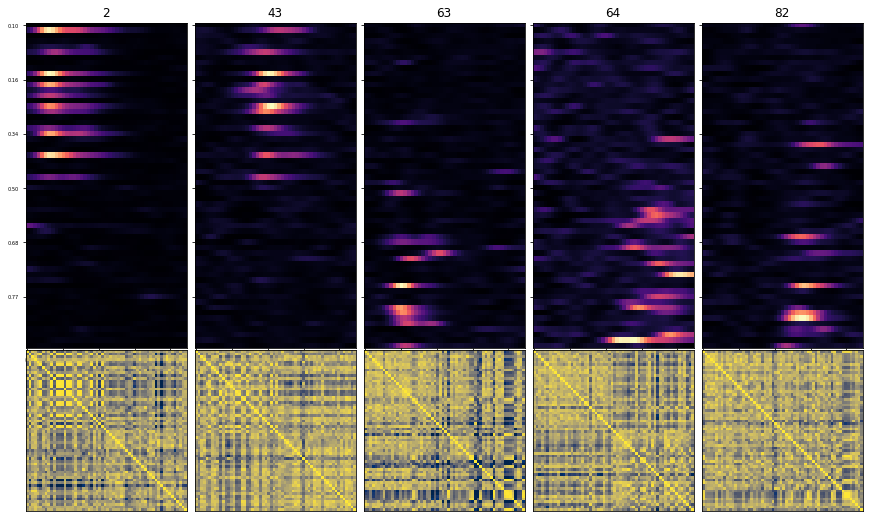

In [68]:
mouse = '4139260.2'
date = '15_02_2019'
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[-1]
print(sess)
pretty_plot(sess,[2,43,63,64,82])

MouseName                                                4139260.1
DateFolder                                              08_02_2019
SessionNumber                                                    4
Track                                                     Reversal
RewardCount                                                     74
Imaging                                                          1
ImagingRegion                                                   DG
DateTime                                       2019-02-08 00:00:00
data file        G:\My Drive\VR_Data\TwoTower\4139260.1\08_02_2...
scanfile                                                      None
scanmat          G:\My Drive\2P_Data\TwoTower\4139260.1\08_02_2...
s2pfolder        G:\My Drive\2P_Data\TwoTower\4139260.1\08_02_2...
Name: 1393, dtype: object
num aberrant ttls 0.0
24435 (24435,) (24435, 21) 82768
(82768,) (82768, 21)
frame diff 0


C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:326: RuntimeWarning: Mean of empty slice
  zone1_speed[i] = np.nanmean(sub_frame.loc[zone1_mask,'speed'])


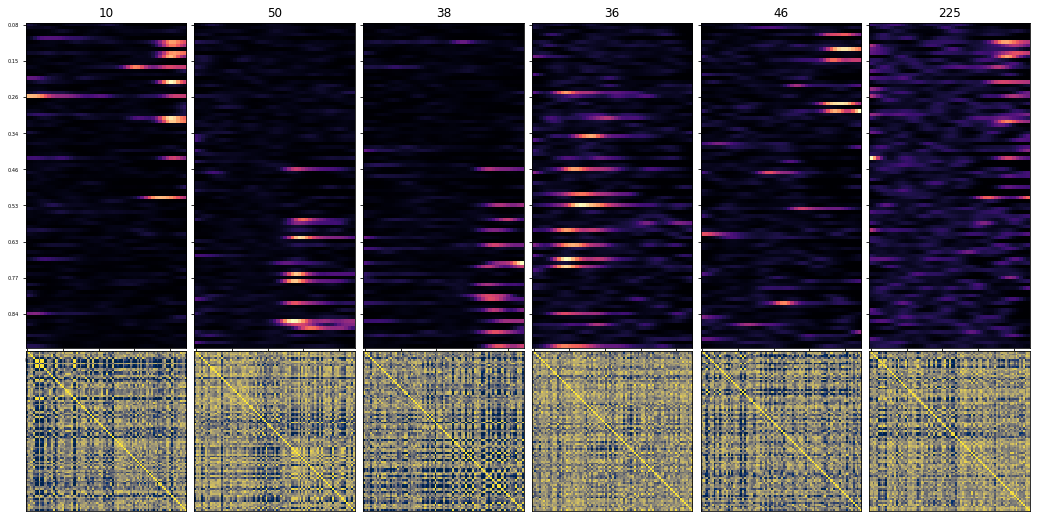

In [69]:
mouse = '4139260.1'
date = '08_02_2019'
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[-1]
print(sess)
pretty_plot(sess,[10,50,38,36,46,225])

In [ ]:
# population place cells and remapping, similarity matrices



In [83]:
FR_dict = {}
FR_dict[0],FR_dict[1]={},{}
basedir = "G:\\My Drive\\Figures\\TwoTower\\SingleSession\\"


for i,(row,sess) in enumerate(df.iterrows()):

    print(sess)
    mouse = sess['MouseName']
    VRDat, C, S, A = pp.load_scan_sess(sess,fneu_coeff=0.7)
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)

    if np.unique(trial_info['morphs']).shape[0]>2:
    
        S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)
        S_trial_mat[np.isnan(S_trial_mat)]=0



        S_morph_dict = u.trial_type_dict(S_trial_mat,trial_info['morphs'])

        S_mu,l = u.across_trial_avg(S_trial_mat,trial_info['morphs'])
        if i==0:
            MU = S_mu
        else:
            MU = np.concatenate((MU,S_mu),axis=-1)


        pc_file = os.path.join(basedir,mouse,"%s_%s_%i" % (sess['Track'],sess['DateFolder'],sess['SessionNumber']),'pc_masks.pkl')
        try:
            with open(pc_file,'rb') as f:
                masks = pickle.load(f)['masks']
        except:
            masks, FR, SI = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                    VRDat['tstart']._values, VRDat['teleport']._values,
                    method='bootstrap',correct_only=False,speed=VRDat.speed._values,
                    win_trial_perm=True,morphlist=[0,1])
            with open(pc_file,'wb') as f:
                pickle.dump({'masks':masks},f)

        fr_dict = pc.plot_placecells(S_morph_dict,masks,plot=False)


        for sort in [0,1]:
            for m in [0,.25,.5,.75,1.]:
                if i==0:

                    FR_dict[sort][m] = fr_dict[sort][m]
                else:
                    FR_dict[sort][m]=np.concatenate((FR_dict[sort][m],fr_dict[sort][m]),axis=0)


MouseName                                                4139219.2
DateFolder                                              25_10_2018
SessionNumber                                                    2
Track                                             TwoTower_Timeout
RewardCount                                                     49
Imaging                                                          1
ImagingRegion                                                   DG
DateTime                                       2018-10-25 00:00:00
data file        G:\My Drive\VR_Data\TwoTower\4139219.2\25_10_2...
scanfile         G:\My Drive\2P_Data\TwoTower\4139219.2\25_10_2...
scanmat          G:\My Drive\2P_Data\TwoTower\4139219.2\25_10_2...
s2pfolder        G:\My Drive\2P_Data\TwoTower\4139219.2\25_10_2...
Name: 900, dtype: object
num aberrant ttls 0.0
16387 (16387,) (16387, 20) 50817
(50817,) (50817, 20)
frame diff 0
MouseName                                                4139219.2
DateFolder     

C:\Users\mplitt\MightyMorphingPhotonRangers\utilities.py:325: RuntimeWarning: Mean of empty slice
  zone0_speed[i]=np.nanmean(sub_frame.loc[zone0_mask,'speed'])


MouseName                                                4139261.2
DateFolder                                              04_02_2019
SessionNumber                                                    3
Track                                                     Reversal
RewardCount                                                     27
Imaging                                                          1
ImagingRegion                                                   DG
DateTime                                       2019-02-04 00:00:00
data file        G:\My Drive\VR_Data\TwoTower\4139261.2\04_02_2...
scanfile                                                      None
scanmat          G:\My Drive\2P_Data\TwoTower\4139261.2\04_02_2...
s2pfolder        G:\My Drive\2P_Data\TwoTower\4139261.2\04_02_2...
Name: 1306, dtype: object
num aberrant ttls 399.0
18199 (18199,) (18199, 21) 57415
(57415,) (57415, 21)
frame diff 0
start bootstrap
end bootstrap
start bootstrap
end bootstrap
MouseName          

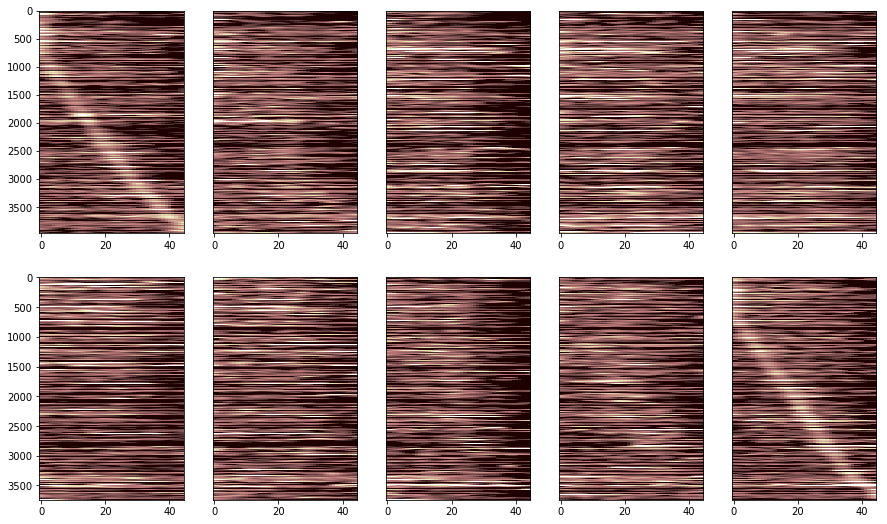

In [89]:
f,ax = plt.subplots(2,5,figsize=[15,9])
getSort = lambda fr : np.argsort(np.argmax(np.squeeze(fr),axis=1))
sort0= getSort(FR_dict[0][0])
sort1 = getSort(FR_dict[1][1])
for i,sort in enumerate([sort0,sort1]):
    for j,m in enumerate([0,.25,.5,.75,1]):
        ax[i,j].imshow(FR_dict[i][m][sort,:],aspect='auto',cmap='pink',vmin=0.2,vmax=.9)
        
        if j>0:
            ax[i,j].set_yticks([])

f.savefig("G:\\My Drive\\manuscripts\\DG_R01Data\\pop_placecells.pdf",format='pdf')

In [90]:
print(MU.shape)

(5, 45, 6365)


In [92]:
MU_f = np.reshape(MU,[MU.shape[0],-1])
MU_f = MU_f/np.linalg.norm(MU_f,ord=2,axis=-1)[:,np.newaxis]
SM = np.matmul(MU_f,MU_f.T)


[[1.         0.71160061 0.61575902 0.58040174 0.61364133]
 [0.71160061 1.         0.63550013 0.61087705 0.64630376]
 [0.61575902 0.63550013 1.         0.67475327 0.71412911]
 [0.58040174 0.61087705 0.67475327 1.         0.75915085]
 [0.61364133 0.64630376 0.71412911 0.75915085 1.        ]]


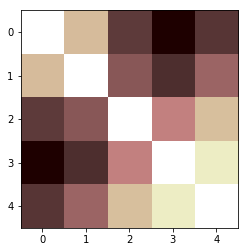

In [102]:
f,ax = plt.subplots()
print(SM)
ax.imshow(SM,cmap='pink',vmax=.8,vmin=.6)
f.savefig("G:\\My Drive\\manuscripts\\DG_R01Data\\average_sim.pdf",format='pdf')

In [116]:
# find CA3 data
# find all DG data
df = pp.load_session_db()
df = df[df['RewardCount']>0]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])

df = df[(df.ImagingRegion=='CA1/CA3') | (df.ImagingRegion=='CA2/CA3') | (df.ImagingRegion=='CA3') | (df.ImagingRegion=='ca3')]


G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [117]:
df

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1361,4139261.1,06_02_2019,1,TwoTower_foraging,60,1,CA1/CA3,2019-02-06,G:\My Drive\VR_Data\TwoTower\4139261.1\06_02_2...,None,G:\My Drive\2P_Data\TwoTower\4139261.1\06_02_2...,None
1807,4222153.3,15_04_2019,3,TwoTower_foraging,40,1,CA2/CA3,2019-04-15,G:\My Drive\VR_Data\TwoTower\4222153.3\15_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.3\15_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.3\15_04_2...


In [ ]:
# do something similar

In [125]:
diam = lambda wd : 2.*wd*np.tan(np.arcsin(.8/1.33))

In [126]:
print(diam(3.),diam(1.9))

4.51765956447285 2.861184390832805


In [127]:
sess = df.iloc[-1]

In [128]:
VRDat,C, S, A = pp.load_scan_sess(sess)
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)


num aberrant ttls 0.0
13661 (13661,) (13661, 21) 44097
(44097,) (44097, 21)


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


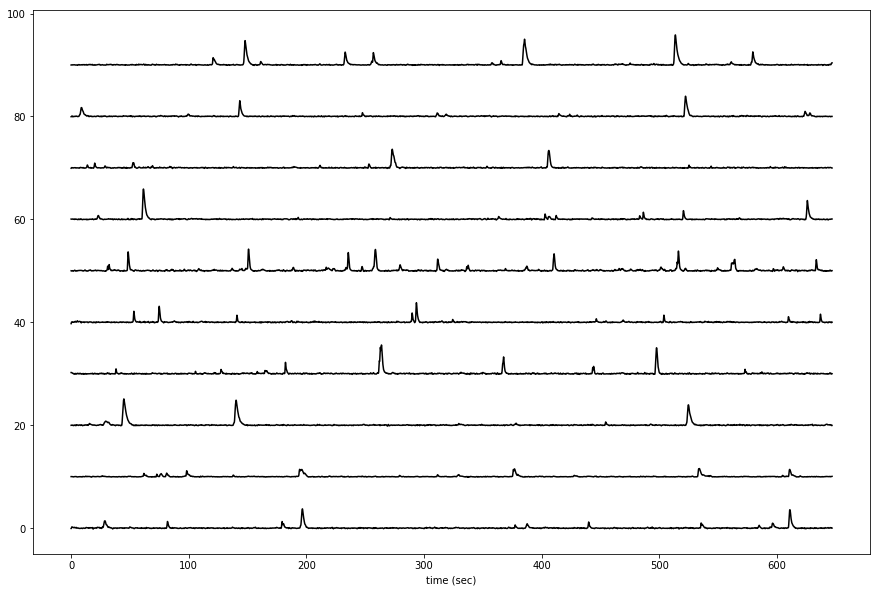

In [130]:
f,ax = plt.subplots(figsize=[15,10])
for i in range(10):
    ax.plot(np.arange(0,10000/15.46,1/15.46),C[:10000,i]+i*10,color='black')
    
ax.set_xlabel('time (sec)')
f.savefig("G:\\My Drive\\manuscripts\\DG_R01Data\\example_CA3_dff.pdf",format='pdf')